<a href="https://colab.research.google.com/github/apthagowda97/pytorch_poc/blob/master/classification/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits:<br>
Transfer learning tutorial from Pytorch/tutorials. [Link](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial)

In [1]:
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip >> /dev/null

--2020-08-17 18:02:11--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.166.17, 13.224.166.129, 13.224.166.66, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.166.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   161MB/s    in 0.3s    

2020-08-17 18:02:11 (161 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current Device:',device)

Current Device: cuda:0


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


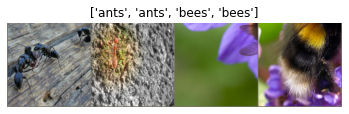

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6495 Acc: 0.6721
val Loss: 0.4432 Acc: 0.7974
Epoch 1/24
----------
train Loss: 0.5962 Acc: 0.7664
val Loss: 0.3041 Acc: 0.8889
Epoch 2/24
----------
train Loss: 0.8960 Acc: 0.7008
val Loss: 0.3574 Acc: 0.8693
Epoch 3/24
----------
train Loss: 0.5407 Acc: 0.7787
val Loss: 0.9061 Acc: 0.7124
Epoch 4/24
----------
train Loss: 0.5076 Acc: 0.7623
val Loss: 0.2633 Acc: 0.9020
Epoch 5/24
----------
train Loss: 0.4671 Acc: 0.8156
val Loss: 0.2502 Acc: 0.8889
Epoch 6/24
----------
train Loss: 0.6425 Acc: 0.7664
val Loss: 0.3779 Acc: 0.8562
Epoch 7/24
----------
train Loss: 0.3410 Acc: 0.8607
val Loss: 0.2149 Acc: 0.9346
Epoch 8/24
----------
train Loss: 0.2372 Acc: 0.8893
val Loss: 0.1903 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.3585 Acc: 0.8402
val Loss: 0.2088 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.2992 Acc: 0.8730
val Loss: 0.1835 Acc: 0.9412
Epoch 11/24
----------
train Loss: 0.2352 Acc: 0.9139
val Loss: 0.1788 Acc: 0.9281
Epoch 12/24
--

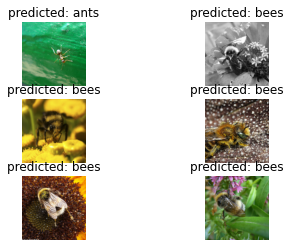

In [15]:
visualize_model(model_ft)

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5430 Acc: 0.7008
val Loss: 0.1861 Acc: 0.9477
Epoch 1/24
----------
train Loss: 0.4399 Acc: 0.7951
val Loss: 0.2253 Acc: 0.9281
Epoch 2/24
----------
train Loss: 0.3730 Acc: 0.7992
val Loss: 0.3131 Acc: 0.8693
Epoch 3/24
----------
train Loss: 0.4981 Acc: 0.7910
val Loss: 0.4111 Acc: 0.8366
Epoch 4/24
----------
train Loss: 0.4026 Acc: 0.8238
val Loss: 0.2698 Acc: 0.9020
Epoch 5/24
----------
train Loss: 0.4071 Acc: 0.8074
val Loss: 0.2537 Acc: 0.9216
Epoch 6/24
----------
train Loss: 0.5484 Acc: 0.7869
val Loss: 0.2190 Acc: 0.9216
Epoch 7/24
----------
train Loss: 0.3148 Acc: 0.8525
val Loss: 0.2071 Acc: 0.9412
Epoch 8/24
----------
train Loss: 0.3812 Acc: 0.8238
val Loss: 0.1807 Acc: 0.9412
Epoch 9/24
----------
train Loss: 0.3666 Acc: 0.8238
val Loss: 0.1907 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.3497 Acc: 0.8238
val Loss: 0.1939 Acc: 0.9281
Epoch 11/24
----------
train Loss: 0.3472 Acc: 0.8443
val Loss: 0.1983 Acc: 0.9281
Epoch 12/24
--

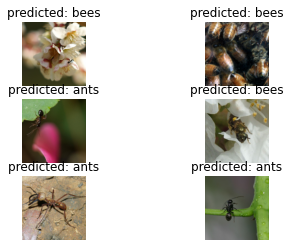

In [19]:
visualize_model(model_conv)